@author: SteveEckel

This example covers calculating the forces in a one-dimensional MOT in the
approximation of an $F=0\rightarrow F=1$.  We then compare this to some simple analytic
expressions.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
plt.style.use('paper')

Let's start this example by considering the simplest of all forces, two
identical polarization beams (relative to their $\mathbf{k}$ vectors), coming in from
either side.

Text(0.5, 0, '$x$')

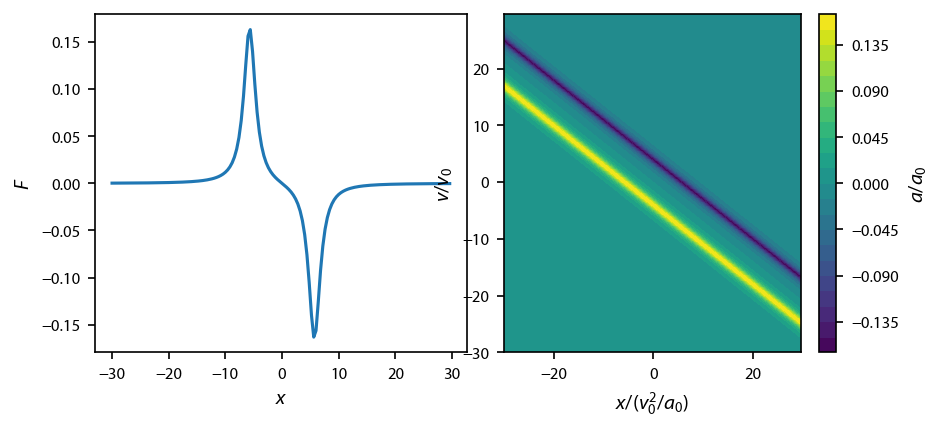

In [13]:
def dimForce(x, v, delta, beta, alpha, totbeta):
    return beta(x)/2*\
               (1/(1 + totbeta(x) + 4*(delta - v - alpha*x)**2) - \
                1/(1 + totbeta(x) + 4*(delta + v + alpha*x)**2))

x = np.arange(-30, 30, 0.4)
v = np.arange(-30, 30, 0.4)

X, V = np.meshgrid(x, v)

det = -4.0
alpha = 0.7
# beta = 0.01 # This is useful to eliminate the effects of power broadening.
beta = 1 # This is standard
nb = 2.0

F = dimForce(X, V, det, lambda x: beta, alpha, lambda x: nb*beta)

fig, ax = plt.subplots(nrows=1, ncols=2, num="Expression", figsize=(6.5, 2.75))
im1 = ax[1].contourf(X, V, F, 25)
cb1 = plt.colorbar(im1)
cb1.set_label('$a/a_0$')
ax[1].set_xlabel('$x/(v_0^2/a_0)$')
ax[1].set_ylabel('$v/v_0$')

ax[0].plot(x, F[int(np.ceil(F.shape[0]/2)), :])
ax[0].set_ylabel('$F$')
ax[0].set_xlabel('$x$')

Next, let's consider a real $F=0\rightarrow F=1$ atom and solve for the force using the
rate equations.  This should correct the simple approximation for the total
saturation intensity in the denominator of our simple expression and reduce the
power broadening slightly.

In [14]:
# Define the atomic Hamiltonian:
Hg, mugq = pylcp.hamiltonians.singleF(F=0, muB=1)
He, mueq = pylcp.hamiltonians.singleF(F=1, muB=1)

dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq)

# Define the laser beams:
laserBeams = pylcp.laserBeams([{'kvec':np.array([1., 0., 0.]), 'beta': beta, 'pol':-1, 'delta':det},
                               {'kvec':np.array([-1., 0., 0.]), 'beta': beta, 'pol':-1, 'delta':det}])
linGrad = lambda R: -alpha*R

trap = pylcp.trap_rateeq(laserBeams, linGrad, ham)

Rvec = np.array([X, np.zeros(X.shape), np.zeros(X.shape)])
Vvec = np.array([V, np.zeros(V.shape), np.zeros(V.shape)])
trap.generate_force_profile(Rvec, Vvec, name='Fx')
F2 = trap.profile['Fx'].F[0]

Plot 'er up:

Text(0.5, 0, '$x$')

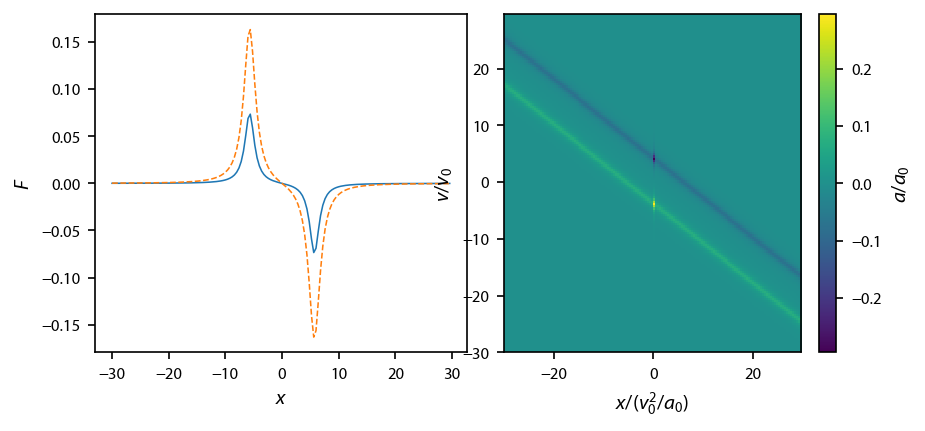

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, num="Expression", figsize=(6.5, 2.75))
im1 = ax[1].imshow(F2, extent=(np.amin(X[0, :]), np.amax(X[0, :]),
                               np.amin(V[:, 0]), np.amax(V[:, 0])),
                   aspect='auto',
                   origin='bottom')
cb1 = plt.colorbar(im1)
cb1.set_label('$a/a_0$')
ax[1].set_xlabel('$x/(v_0^2/a_0)$')
ax[1].set_ylabel('$v/v_0$')

ax[0].plot(x, F2[int(np.ceil(F.shape[0]/2)), :], '-', color='C0', linewidth=0.75)
ax[0].plot(x, F[int(np.ceil(F.shape[0]/2)), :], '--', color='C1', linewidth=0.75)
ax[0].set_ylabel('$F$')
ax[0].set_xlabel('$x$')

Now, let's compute the trap frequencies of the two and compare to standard
1D theory.

In [16]:
dets = np.array([-4., -3., -2., -1.])
betas = np.linspace(0.01, 10**1.5 , 61)

omegasqrd = np.zeros(betas.shape + dets.shape)
dampingcoeff = np.zeros(betas.shape + dets.shape)

omegasqrd_simple = np.zeros(betas.shape + dets.shape)
dampingcoeff_simple = np.zeros(betas.shape + dets.shape)

for ii, det in enumerate(dets):
    for jj, beta in enumerate(betas):
        # Define the laser beams:
        laserBeams = [None]*2
        laserBeams[0] = pylcp.laserBeam(kvec=np.array([1., 0., 0.]), beta=beta, pol=-1,
                                        delta=det)
        laserBeams[1] = pylcp.laserBeam(kvec=np.array([-1., 0., 0.]), beta=beta, pol=-1,
                                        delta=det)

        # Luckily, we know exactly where the center of the MOT is, so we don't
        # need to find it first.  (A must in non-symmetric geometries).
        DerVec = np.array([[-0.0001,0.0001],[0.0, 0.0,],[0.0, 0.0]])
        StatVec = np.array([[1e-9, 1e-9],[0.0, 0.0,],[0.0, 0.0]])

        trap = pylcp.trap_rateeq(laserBeams, linGrad, ham, svd_eps=1e-10)
        omegasqrd[jj, ii] = trap.trapping_frequencies(axes=[0], eps=0.0002)
        dampingcoeff[jj, ii] = trap.damping_coeff(axes=[0], eps=0.0002)

fig, ax = plt.subplots(1,2)
for ii, det in enumerate(dets):
    ax[0].plot(betas, omegasqrd[:, ii], '-', color='C{0:d}'.format(ii))
    ax[0].plot(betas, -8*0.7*det*betas/(1 + betas + 4*det**2)**2, 'k-', linewidth=0.5)
    ax[1].plot(betas, dampingcoeff[:, ii], '-', color='C{0:d}'.format(ii))
    ax[1].plot(betas, -8*det*betas/(1 + betas + 4*det**2)**2, 'k-', linewidth=0.5)

TypeError: 'NoneType' object is not subscriptable